<a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"> <img src="images/DLI Header.png" alt="Header" style="width: 200px;"/> </a>

<a href="https://www.mayoclinic.org/"><img src="images/mayologo.png" alt="Mayo Logo"></a>
### Medical Image Classification Using the MedNIST Dataset
#### This model is heavily inspired by <a href="https://github.com/apolanco3225/Medical-MNIST-Classification">V1
     Where the architucture of the used model in V1 has been modified and also alot of hyperparameters

### 1. Import packages

In [1]:
import numpy as np
import os
import time
%matplotlib inline
import matplotlib.pyplot as mp
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as om
import torchvision as tv
import torch.utils.data as dat
from sklearn.metrics import classification_report
import seaborn as sns

### 2. Congigure Torch

In [2]:
if torch.cuda.is_available():     # Make sure GPU is available
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
else:
    print("Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")

np.random.seed(551)

C:\Users\utilisateur\anaconda3\envs\mednist\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


### 3. Loading Data and Creating Datasets

#### 1. Discover available data

In [3]:
# The main data directory
dataDir = 'resized'               
classNames = os.listdir(dataDir)  # Each type of image can be found in its own subdirectory
numClass = len(classNames)        # Number of types = number of subdirectories
# The dimensions of each image
print("We have {} classes:".format(str(numClass)), classNames)
# imageFiles is a list of 6 list, each list contains the name of image file in this subdirectory
imageFiles = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                     # A nested list of filenames
numEach = [len(imageFiles[i]) for i in range(numClass)]     # A count of each type of image
for class_name, num in zip(classNames,numEach):
    print(class_name, "contains ",num)

We have 6 classes: ['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']
AbdomenCT contains  10000
BreastMRI contains  8954
ChestCT contains  10000
CXR contains  10000
Hand contains  10000
HeadCT contains  10000


######          Put it all together

In [4]:
imageFilesList = []               # Created an un-nested list of filenames
imageClass = []                   # The labels -- the type of each individual image in the list
for i in range(numClass):
    imageFilesList.extend(imageFiles[i])
    imageClass.extend([i]*numEach[i])
numTotal = len(imageClass)        # Total number of images
imageWidth, imageHeight = Image.open(imageFilesList[0]).size 
print("There are",numTotal,"images in",numClass,"distinct categories")
print("Image dimensions:",imageWidth,"x",imageHeight)

There are 58954 images in 6 distinct categories
Image dimensions: 64 x 64


#### 2. Normalize & Centralize the pixels in the images

In [5]:
toTensor = tv.transforms.ToTensor()
def scaleImage(x):
    # Pass a PIL image, return a tensor
    y = toTensor(x)
    # print(y.size())
    # print(y)
    if(y.min() < y.max()):  # Assuming the image isn't empty, rescale so its values run from 0 to 1
        y = (y - y.min())/(y.max() - y.min()) # normalize pixels
    z = y - y.mean()        # Subtract the mean value of the image i.e centralize it
    return z

Put all images in one tensor, normalize & centralize them. Put all labels in one tensor

In [6]:
imageTensor = torch.stack([scaleImage(Image.open(x)) for x in imageFilesList])  # Load, scale, and stack image (X) tensor
classTensor = torch.tensor(imageClass)  # Create label (Y) tensor
print("Rescaled min pixel value = {:1.3}; Max = {:1.3}; Mean = {:1.3}"
      .format(imageTensor.min().item(),imageTensor.max().item(),imageTensor.mean().item()))

Rescaled min pixel value = -0.786; Max = 0.972; Mean = -3.35e-09


In [7]:
print("The size of images tensor",imageTensor.size())
print("The size of labels tensor",classTensor.size())

The size of images tensor torch.Size([58954, 1, 64, 64])
The size of labels tensor torch.Size([58954])


#### 3. Create train & validate & test datasets

In [8]:
validFrac = 0.1   # Define the fraction of images to move to validation dataset
testFrac = 0.1    # Define the fraction of images to move to test dataset
validList = []
testList = []
trainList = []

for i in range(numTotal):
    rann = np.random.random() # Randomly reassign images (Return random floats in the half-open interval [0.0, 1.0).)
    if rann < validFrac:
        validList.append(i)
    elif rann < testFrac + validFrac:
        testList.append(i)
    else:
        trainList.append(i)       
nTrain = len(trainList)  # Count the number in each set
nValid = len(validList)
nTest = len(testList)
print("Training images =",nTrain,"Validation =",nValid,"Testing =",nTest)

Training images = 47230 Validation = 5878 Testing = 5846


In [9]:
trainIds = torch.tensor(trainList)    # Slice the big image and label tensors up into
validIds = torch.tensor(validList)    #       training, validation, and testing tensors
testIds = torch.tensor(testList)
# create tensor for train
trainX = imageTensor[trainIds,:,:,:]
trainY = classTensor[trainIds]
print("Train dataset size is:",trainX.size())
# create tensor for validate
validX = imageTensor[validIds,:,:,:]
validY = classTensor[validIds]
print("Validate dataset size is:",validX.size())
# create tensor for test
testX = imageTensor[testIds,:,:,:]
testY = classTensor[testIds]
print("Test dataset size is:",testX.size())

Train dataset size is: torch.Size([47230, 1, 64, 64])
Validate dataset size is: torch.Size([5878, 1, 64, 64])
Test dataset size is: torch.Size([5846, 1, 64, 64])


### 4. CNN Model

In [10]:
class MedNet(nn.Module):
    def __init__(self,xDim,yDim,numC): # Pass image dimensions and number of labels when initializing a model   
        super(MedNet,self).__init__()  # Extends the basic nn.Module to the MedNet class
        
        numConvs1 = 12
        convSize1 = 3
        numConvs2 = 20
        convSize2 = 3
        fcSize1 = 400
        fcSize2 = 80
        # numNodesToFC = numConvs2*(xDim-(convSize1-1)-(convSize2-1))*(yDim-(convSize1-1)-(convSize2-1))   

        # nn.Conv2d(channels in, channels out, convolution height/width)
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        # 1 channel -- grayscale -- feeds into the first convolution. The same number output from one layer must be
        # fed into the next. These variables actually store the weights between layers for the model.
        
        #Input shape= (batch_size,1,64,64)
        self.conv1=nn.Conv2d(in_channels=1,out_channels=numConvs1
                             ,kernel_size=3,stride=1,padding=1)
        #Shape= (batch_size,12,64,64)
        self.bn1=nn.BatchNorm2d(num_features=numConvs1)
        #Shape= (batch_size,12,64,64)
        #Reduce the image size be factor 2
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Shape= (batch_size,12,32,32)
        
        self.conv2=nn.Conv2d(in_channels=numConvs1,out_channels=numConvs2,kernel_size=3,stride=1,padding=1)
        #Shape= (batch_size,20,32,32)
        self.bn2=nn.BatchNorm2d(num_features=numConvs2)
        #Shape= (batch_size,20,32,32)        
        # nn.Linear(nodes in, nodes out)
        # Stores the weights between the fully connected layers
        self.ful1 = nn.Linear(numConvs2*32*32,fcSize1)
        # self.ful1 = nn.Linear(numConvs2*16*16,fcSize1)
        self.drop1 = nn.Dropout(0.5) #20% probability
        self.ful2 = nn.Linear(fcSize1, fcSize2)
        self.drop2 = nn.Dropout(0.5) #50% probability
        self.ful3 = nn.Linear(fcSize2,numC)
        
    def forward(self,x):
        # This defines the steps used in the computation of output from input.
        # It makes uses of the weights defined in the __init__ method.
        # Each assignment of x here is the result of feeding the input up through one layer.
        # Here we use the activation function elu, which is a smoother version of the popular relu function.
        
        x=self.conv1(x)
        x = F.elu(self.bn1(x)) # Feed through first convolutional layer, then apply activation            
        x=self.pool(x)
            
        x=self.conv2(x)
        x = F.elu(self.bn2(x)) # Feed through second convolutional layer, apply activation
        # x=self.pool(x)
        x = x.view(-1,self.num_flat_features(x)) # Flatten convolutional layer into fully connected layer
        x = self.ful1(x)
        # x = self.drop1(F.elu(self.ful1(x)))
        # x = F.elu(x) # Feed through first fully connected layer, apply activation
        x = self.ful2(x)
        # x = self.drop2( F.elu(self.ful2(x)))
        x = self.ful3(x)        # Final FC layer to output. No activation, because it's used to calculate loss
        return x

    def num_flat_features(self, x):  # Count the individual nodes in a layer
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### 5. Setup the parameters for the training process

***Define object of CNN model***

In [11]:
model = MedNet(imageWidth,imageHeight,numClass).to(dev)

***Increase the weight for imbalanced clacces***

In [12]:
CEweights = torch.zeros(numClass)     # This takes into account the imbalanced dataset.
# print(CEweights)
# for rach class we have, we increase its corresponding value in CEweights by one
for i in trainY.tolist():             #      By making rarer images count more to the loss, 
    CEweights[i].add_(1)              #      we prevent the model from ignoring them.
print(CEweights)
# bound the wieght into 1
CEweights = 1. / CEweights.clamp_(min=1.)                     # Weights should be inversely related to count
print(CEweights)
CEweights = (CEweights * numClass / CEweights.sum()).to(dev)  # The weights average to 1
print(CEweights)

tensor([7983., 7247., 8010., 7986., 8028., 7976.])
tensor([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001])
tensor([0.9847, 1.0847, 0.9814, 0.9844, 0.9792, 0.9856])


****Define hyperparameters****

In [13]:
learnRate = 0.01          # Define a learning rate.
# maxEpochs = 20            # Maximum training epochs
maxEpochs = 3 
t2vRatio = 1.2            # Maximum allowed ratio of validation to training loss
t2vEpochs = 3             # Number of consecutive epochs before halting if validation loss exceeds above limit
# batchSize = 300           # Batch size. Going too large will cause an out-of-memory error.
batchSize = 16          # Batch size. Going too large will cause an out-of-memory error.

trainBats = nTrain // batchSize       # Number of training batches per epoch. Round down to simplify last batch
validBats = nValid // batchSize       # Validation batches. Round down
testBats = -(-nTest // batchSize)     # Testing batches. Round up to include all

print("Number of train Batchs:",trainBats)
print("Number of valid Batchs:",validBats)
print("Number of test Batchs:",testBats)

Number of train Batchs: 2951
Number of valid Batchs: 367
Number of test Batchs: 366


***Define optimiser***

In [14]:
# Initialize an optimizer
opti = om.SGD(model.parameters(), lr = learnRate) 

### 6. Train the CNN model

In [15]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

In [16]:
for i in range(maxEpochs):
    # Train the model
    model.train()                     # Set model to training mode
    epochLoss = 0.
    permute = torch.randperm(nTrain)  # Shuffle data to randomize batches
    trainX = trainX[permute,:,:,:]
    trainY = trainY[permute]
    for j in range(trainBats):        # Iterate over batches
        opti.zero_grad()              # Zero out gradient accumulated in optimizer
        batX = trainX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   # Slice shuffled data into batches
        batY = trainY[j*batchSize:(j+1)*batchSize].to(dev)         # .to(dev) moves these batches to the GPU
        yOut = model(batX)            # Evalute predictions
        loss = F.cross_entropy(yOut, batY,weight=CEweights)        # Compute loss
        epochLoss += loss.item()      # Add loss
        loss.backward()               # Backpropagate loss
        opti.step() # Update model weights using optimizer
    # Evaluate the model
    validLoss = 0.
    permute = torch.randperm(nValid)  # We go through the exact same steps, without backprop / optimization
    validX = validX[permute,:,:,:]    # in order to evaluate the validation loss
    validY = validY[permute]
    model.eval()                      # Set model to evaluation mode
    with torch.no_grad():             # Temporarily turn off gradient descent
        for j in range(validBats):
            opti.zero_grad()
            batX = validX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
            batY = validY[j*batchSize:(j+1)*batchSize].to(dev)
            yOut = model(batX)
            validLoss += F.cross_entropy(yOut, batY,weight=CEweights).item()
    epochLoss /= trainBats            # Average loss over batches and print
    validLoss /= validBats
    # Store the loss value for plotting the learning curve.
    loss_values.append(epochLoss)
    validation_loss_values.append(validLoss)
    print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))
    if validLoss > t2vRatio * epochLoss:
        t2vEpochs -= 1                # Test if validation loss exceeds halting threshold
        if t2vEpochs < 1:
            print("Validation loss too high; halting to prevent overfitting")
            break

Epoch =   0; Training loss = 0.0276; Validation loss = 0.0063
Epoch =   1; Training loss = 0.0038; Validation loss = 0.0045
Epoch =   2; Training loss = 0.0021; Validation loss = 0.0044


#### Visualize the learning curve

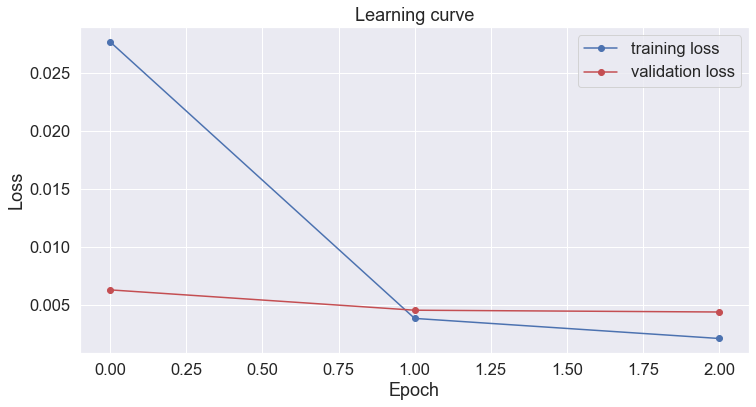

In [17]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
mp.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
mp.plot(loss_values, 'b-o', label="training loss")
mp.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
mp.title("Learning curve")
mp.xlabel("Epoch")
mp.ylabel("Loss")
mp.legend()

mp.show()

### 7. Evaluate the model on test dataset

In [18]:
def count_labels(lis: torch.tensor):
    labels_count = torch.zeros(numClass)     # This takes into account the imbalanced dataset.
# for rach class we have we increase its corresponding value in CEweights by one
    for i in lis.tolist():             #      By making rarer images count more to the loss, 
        labels_count[i].add_(1)
    return labels_count

In [19]:
predictions = []
confuseMtx = np.zeros((numClass,numClass),dtype=int)    # Create empty confusion matrix
model.eval()
with torch.no_grad():
    permute = torch.randperm(nTest)                     # Shuffle test data
    testX = testX[permute,:,:,:]
    testY = testY[permute]
    test_labels = count_labels(testY)
    for j in range(testBats):                           # Iterate over test batches
        batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
        batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
        yOut = model(batX)                              # Pass test batch through model
        pred = yOut.max(1,keepdim=True)[1]
        pred_list = [pred_value[0] for pred_value in pred.tolist()]
        # print(pred.tolist())
        # print(pred_list)
        predictions.extend(pred_list)
        # Generate predictions by finding the max Y values
        for j in torch.cat((batY.view_as(pred), pred),dim=1).tolist(): # Glue together Actual and Predicted to
            confuseMtx[j[0],j[1]] += 1                  # make (row, col) pairs, and increment confusion matrix

#### Visualize the partition of labels in the test dataset

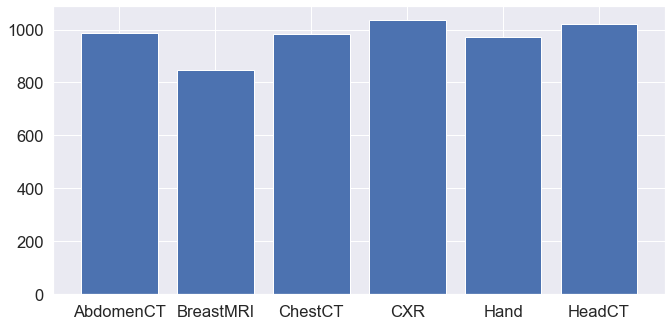

In [20]:
fig = mp.figure()
fig.set_size_inches(8.5, 4)
ax = fig.add_axes([0,0,1,1])
ax.bar(classNames,test_labels)
mp.show()

#### Confusion matrix on test dataset

In [21]:
correct = sum([confuseMtx[i,i] for i in range(numClass)])   # Sum over diagonal elements to count correct predictions
print("Correct predictions: ",correct,"of",nTest)
print("Accuracy on test dataset", correct/nTest)
print("Confusion Matrix:")
print(confuseMtx)
print(classNames)

Correct predictions:  5837 of 5846
Accuracy on test dataset 0.998460485802258
Confusion Matrix:
[[ 986    0    0    0    0    0]
 [   0  847    0    0    0    0]
 [   0    0  983    0    0    0]
 [   0    0    0 1033    3    0]
 [   1    0    0    3  968    1]
 [   0    1    0    0    0 1020]]
['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']


***Get the metrics for each classe***

In [22]:
print(classification_report(testY.tolist(),predictions,target_names=classNames))

              precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00       986
   BreastMRI       1.00      1.00      1.00       847
     ChestCT       1.00      1.00      1.00       983
         CXR       1.00      1.00      1.00      1036
        Hand       1.00      0.99      1.00       973
      HeadCT       1.00      1.00      1.00      1021

    accuracy                           1.00      5846
   macro avg       1.00      1.00      1.00      5846
weighted avg       1.00      1.00      1.00      5846



***Get the images that confus the model***

In [23]:
# Scale the image back to its basic contrast
def scaleBack(x):               # Pass a tensor, return a numpy array from 0 to 1
    if(x.min() < x.max()):      # Assuming the image isn't empty, rescale so its values run from 0 to 1
        x = (x - x.min())/(x.max() - x.min())
    return x[0].to(cpu).numpy() # Remove channel (grayscale anyway)

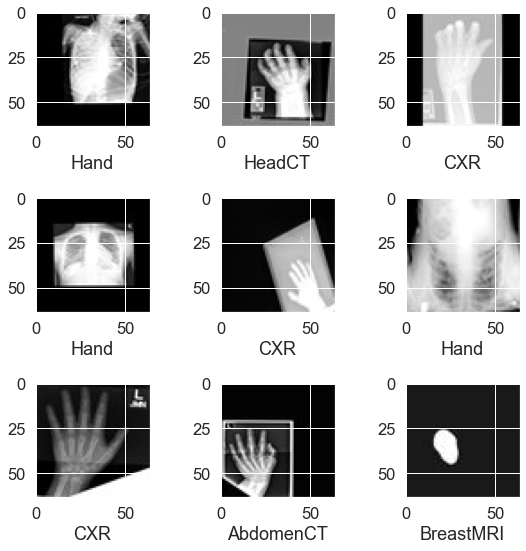

In [24]:
model.eval()
mp.subplots(3,3,figsize=(8,8))
imagesLeft = 9
permute = torch.randperm(nTest)        # Shuffle test data
testX = testX[permute,:,:,:]
testY = testY[permute]
for j in range(testBats):              # Iterate over test batches
    batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
    batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
    yOut = model(batX)                 # Pass test batch through model
    pred = yOut.max(1)[1].tolist()     # Generate predictions by finding the max Y values
    for i, y in enumerate(batY.tolist()):
        if imagesLeft and y != pred[i]:         # Compare the actual y value to the prediction
            imagesLeft -= 1
            mp.subplot(3,3,9-imagesLeft)
            mp.xlabel(classNames[pred[i]])      # Label image with what the model thinks it is
            mp.imshow(scaleBack(batX[i]),cmap='gray',vmin=0,vmax=1)
mp.tight_layout()
mp.show()

In [25]:
model

MedNet(
  (conv1): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ful1): Linear(in_features=20480, out_features=400, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (ful2): Linear(in_features=400, out_features=80, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (ful3): Linear(in_features=80, out_features=6, bias=True)
)

### 8. Save trained model to be used in inference

In [26]:
# Create the right input shape (e.g. for an image)
# dummy_input = scaleImage(Image.open(imageFilesList[1]))
from torch.autograd import Variable
dummy_input = Variable(torch.randn(1, 1, 64, 64)) 
dummy_input

tensor([[[[-0.2775, -1.0646,  0.2177,  ..., -0.1887,  0.1802,  2.4652],
          [ 1.6396, -0.7411, -0.7679,  ..., -0.8523, -1.3694,  1.9763],
          [-0.2770, -0.5968,  0.1379,  ..., -0.7846,  0.3562, -1.9046],
          ...,
          [ 0.7154, -0.6753, -1.3299,  ..., -0.0848,  0.1023,  1.7796],
          [ 0.4246,  0.6277, -0.2441,  ..., -1.7212,  0.9558,  0.1112],
          [-0.1801, -0.4936, -0.3529,  ..., -1.0749, -1.0214,  0.3326]]]])

In [27]:
input_names = [ "actual_input" ]
output_names = [ "output" ]
model_path = os.path.join('../MedNet_App','models','MedNet_v2.onnx')

In [28]:
torch.onnx.export(model, dummy_input, model_path,
                  verbose=False,
                  input_names=input_names,
                  output_names=output_names,
                  export_params=True,
                  )